# Paipote BEP Instance

In [1]:
import numpy as np
import geopandas as gpd
import networkx as nx
import osmnx as ox
import pandas as pd

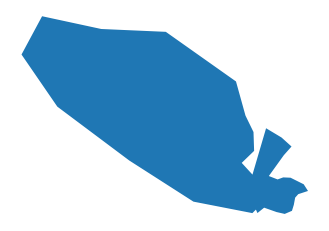

In [2]:
study_area = gpd.read_file('shapes/study_area.shp')
blocks = gpd.read_file('shapes/manzanas_paipote.shp')
yards = gpd.read_file('shapes/bus_yards.shp')
shelters = gpd.read_file('shapes/shelters.shp').iloc[:3]
census = pd.read_csv('shapes/censo2017_manzanas.csv', encoding='utf-8', sep=';')
ax = study_area.plot()
ax.set_axis_off()

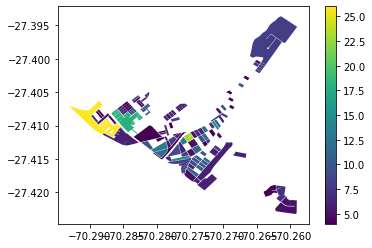

In [3]:
# Construct Elder Blocks from census data
census_copiapo = census.query('COMUNA == 3101')[['ID_MANZENT', 'EDAD_65YMAS']]
elder_pop = census_copiapo.set_index('ID_MANZENT')
blocks['MANZENT_I'] = blocks['MANZENT_I'].astype(np.int64)
elder_pop_paipote = elder_pop.loc[blocks.MANZENT_I].replace('*', 0).astype(int)
blocks = blocks.merge(elder_pop_paipote, how='inner', left_on='MANZENT_I', right_index=True)
blocks_elder = blocks[blocks['EDAD_65YMAS'] != 0]
blocks_elder.plot(column='EDAD_65YMAS', legend=True)

C:\Users\secan\Anaconda3\envs\BEP\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


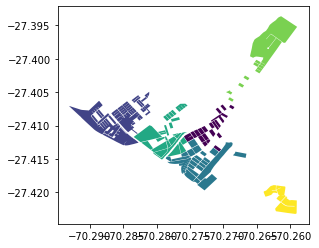

In [4]:
from sklearn.cluster import KMeans

X = np.array([blocks_elder.geometry.representative_point().x.values, blocks_elder.geometry.representative_point().y.values]).T
kmeans = KMeans(n_clusters=6)
c = kmeans.fit_predict(X)
blocks_elder['cluster'] = c
blocks_elder.plot(column='cluster')

In [5]:
blocks_elder.groupby('cluster')['EDAD_65YMAS'].sum()

cluster
0    169
1    139
2    161
3    148
4     42
5     16
Name: EDAD_65YMAS, dtype: int32

In [6]:
# Upper bound for buses
blocks_elder.groupby('cluster')['EDAD_65YMAS'].sum().sum() / 30

22.5

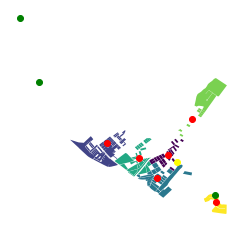

In [7]:
# Get pickup points
from shapely.geometry import Point
pickups = gpd.GeoSeries([Point(x, y) for x, y in kmeans.cluster_centers_])
ax = blocks_elder.plot(column='cluster')
pickups.plot(color='red', ax=ax)
yards.plot(color='yellow', ax=ax)
shelters.plot(color='green', ax=ax)
ax.set_axis_off()

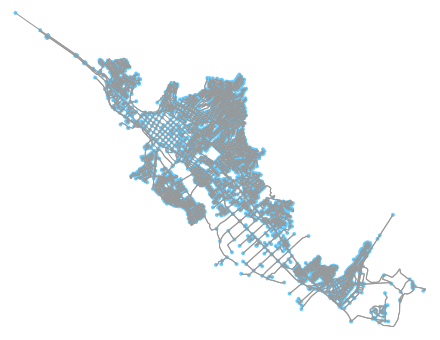

(<Figure size 636.187x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x14611696940>)

In [8]:
G = ox.graph_from_polygon(study_area['geometry'][0], network_type='drive')
ox.plot_graph(G)

In [9]:
nodes = list(yards.geometry) + list(pickups.geometry) + list(shelters.geometry)
nodes0 = list(blocks_elder.geometry.representative_point())
ox_nodes0 = [ox.get_nearest_node(G, (node.y, node.x)) for node in nodes0] 
ox_nodes = [ox.get_nearest_node(G, (node.y, node.x)) for node in nodes]

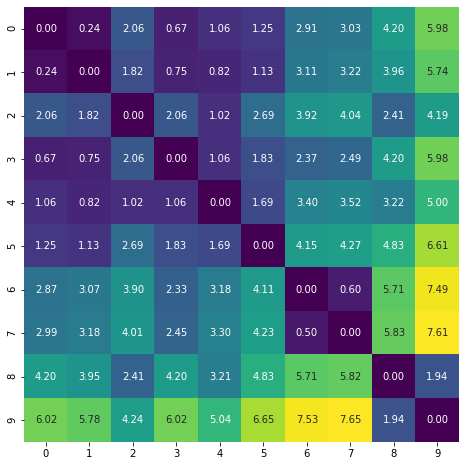

In [10]:
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

# distance matrix
distances = np.zeros((len(ox_nodes), len(ox_nodes)))
for i, j in product(range(len(ox_nodes)), range(len(ox_nodes))):
    distances[i, j] = nx.shortest_path_length(G, source=ox_nodes[i], target=ox_nodes[j], weight='length')

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(distances / 1000, square=True, annot=True, fmt='.2f', ax=ax, cbar=False, cmap='viridis')

fig.savefig('figures/distances.png', tight_layout=True, dpi=400)

In [11]:
distances0 = np.zeros_like(blocks_elder.EDAD_65YMAS.values)
for i, src in enumerate(ox_nodes0):
    distances0[i] = nx.shortest_path_length(G, source=src, target=ox_nodes[1 + blocks_elder.cluster.astype(int).values[i]],
                                           weight='length')
distances0

array([ 347,  310,   83,  194,  373,  593,  471,  593,  619,  619,  703,
        486,  503,  597,    0,  402,  361,  600,  469,  393,  505,  298,
        562,  368,  269,   53,  156,  100,  293,  225,  371,  180,   30,
        165,  371,  125,  189,  234,  606,  540,  304,  234,  295,  559,
        154,  683,  646,  419,  387,  203,  465,  300,  286,  219,  318,
        183,  272,  289,  107,  172,   54,  215,    0,  120,  372,  410,
        126,  761,  688,  665,  516,  467,  419,  419,  371,  319,   30,
        435,  165,  230, 1530,  149,  624,    0,  357,  387,  231])

In [12]:
np.savetxt('instances/paipote/demands.txt', blocks_elder.EDAD_65YMAS.values, fmt='%d')
np.savetxt('instances/paipote/distances0.txt', distances0)
np.savetxt('instances/paipote/buses.txt', np.array([20]), fmt='%d')
np.savetxt('instances/paipote/capacities.txt', np.array([250, 250, 250]).T, fmt='%d')
np.savetxt('instances/paipote/nodes.txt', [[node.x, node.y] for node in nodes])
np.savetxt('instances/paipote/source_nodes.txt', [[node.x, node.y] for node in nodes0])
np.savetxt('instances/paipote/distances.txt', distances)
np.savetxt('instances/paipote/clusters.txt', blocks_elder.cluster.astype(int).values, fmt='%d')

In [13]:
ox_nodes[:1]

[1545875168]

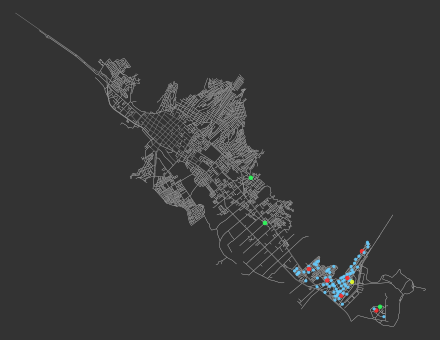

In [14]:
# Instance Figure
node_color = []
node_size = []
for node in G.nodes:
    if node in ox_nodes[:1]:
        node_color.append('#eaff2b')
        node_size.append(20)
    elif node in ox_nodes[1:7]:
        node_color.append('#ff2b2b')
        node_size.append(20)
    elif node in ox_nodes[7:]:
        node_color.append('#2bff59')
        node_size.append(20)
    elif node in ox_nodes0:
        node_color.append('#66ccff')
        node_size.append(10)
    else:
        node_color.append('#66ccff')
        node_size.append(0)
fig, ax = ox.plot_graph(G, node_color=node_color, node_size=node_size, dpi=1500, save=True, node_zorder=3, node_alpha=0.9,
                       bgcolor='#333333', edge_color='#a8a8a8', edge_linewidth=0.3)
ax.scatter([], [], s=20, color='#eaff2b', alpha=0.9, label='Yard')
ax.scatter([], [], s=20, color='#ff2b2b', alpha=0.9, label='Pickup Point')
ax.scatter([], [], s=10, color='#66ccff', alpha=0.9, label='Source Node')
ax.scatter([], [], s=20, color='#2bff59', alpha=0.9, label='Shelter')

L = fig.legend(frameon=False, loc=(0.65, 0.35))
for text in L.get_texts():
    text.set_color("white")
    text.set_fontsize(4)
fig.savefig('instances/paipote/figure.png', dpi=1500, facecolor='#333333')


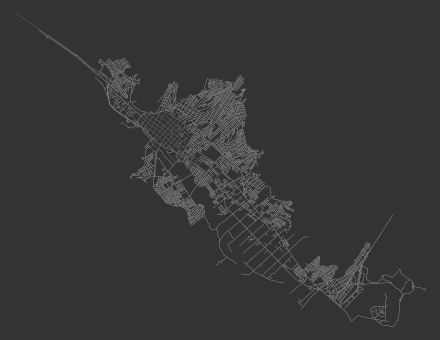

<Figure size 432x288 with 0 Axes>

In [15]:
# Clustered Blocks

fig, ax = ox.plot_graph(G, node_color=node_color, node_size=0, dpi=100, save=True, node_zorder=3, node_alpha=0.9,
                       bgcolor='#333333', edge_color='#a8a8a8', edge_linewidth=0.2)
blocks_elder.plot(column='cluster', ax = ax)
ax.set_axis_off()
fig = ax.get_figure()
fig.savefig('clustered_blocks.png', dpi=1000, facecolor='#333333')

In [16]:
route = [0, 1, 3, 8]
ox_route = [ox_nodes[i] for i in route]
nx_route = [ox_route[0]]
for i in range(len(ox_route[:-1])):
    nx_route += nx.shortest_path(G, source=ox_route[i], target=ox_route[i+1])[1:]

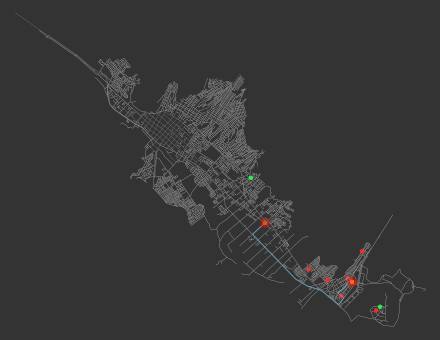

In [17]:
node_color = []
node_size = []
for node in G.nodes:
    if node in ox_nodes[:1]:
        node_color.append('#eaff2b')
        node_size.append(20)
    elif node in ox_nodes[1:7]:
        node_color.append('#ff2b2b')
        node_size.append(20)
    elif node in ox_nodes[7:]:
        node_color.append('#2bff59')
        node_size.append(20)
    elif node in ox_nodes0:
        node_color.append('#66ccff')
        node_size.append(0)
    else:
        node_color.append('#66ccff')
        node_size.append(0)
fig, ax = ox.plot_graph_route(G, nx_route, node_color=node_color, node_size=node_size, dpi=100, save=True, node_zorder=3, node_alpha=0.9,
                       bgcolor='#333333', edge_color='#a8a8a8', edge_linewidth=0.2, route_linewidth=1, route_color='#66ccff')
fig.savefig('instances/paipote/routes/route0.png', dpi=1500, facecolor='#333333')

In [18]:
x = []
with open('instances/paipote/solution_bep/sol_min-max.txt', 'r') as sol_file:
    lines = sol_file.readlines()
    for line in lines:
        if 'x_' in line:
            x.append(tuple(line.split('=')[0].split('_')[1:]))
x

[('0', '1', '0', '1'),
 ('0', '1', '3', '1'),
 ('0', '1', '6', '1'),
 ('0', '1', '10', '1'),
 ('0', '3', '7', '1'),
 ('0', '3', '9', '1'),
 ('0', '3', '11', '1'),
 ('0', '3', '14', '1'),
 ('0', '3', '16', '1'),
 ('0', '3', '17', '1'),
 ('0', '3', '18', '1'),
 ('0', '6', '1', '1'),
 ('0', '6', '2', '1'),
 ('0', '6', '4', '1'),
 ('0', '6', '5', '1'),
 ('0', '6', '8', '1'),
 ('0', '6', '12', '1'),
 ('0', '6', '13', '1'),
 ('0', '6', '15', '1'),
 ('0', '6', '19', '1'),
 ('1', '5', '1', '3'),
 ('1', '5', '6', '2'),
 ('1', '5', '10', '2'),
 ('1', '5', '14', '3'),
 ('1', '6', '0', '2'),
 ('1', '6', '3', '2'),
 ('1', '8', '4', '3'),
 ('1', '8', '9', '3'),
 ('2', '3', '16', '4'),
 ('2', '7', '0', '5'),
 ('2', '9', '19', '3'),
 ('3', '1', '9', '2'),
 ('3', '1', '14', '2'),
 ('3', '2', '0', '4'),
 ('3', '5', '17', '2'),
 ('3', '6', '7', '2'),
 ('3', '6', '16', '2'),
 ('3', '7', '11', '2'),
 ('3', '8', '7', '4'),
 ('3', '8', '16', '5'),
 ('3', '9', '18', '2'),
 ('4', '7', '8', '4'),
 ('5', '6', '2

In [19]:
routes = {}
for m in range(20):
    routes[m] = []
    for t in range(1, 7):
        for i in range(10):
            for j in range(10):
                if (str(i), str(j), str(m), str(t)) in x:
                    routes[m].append((i, j))
for i in routes:
    routes[i] = [routes[i][0][0]] + [dest for src, dest in routes[i]] 

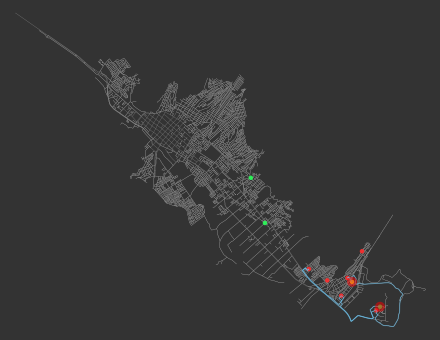

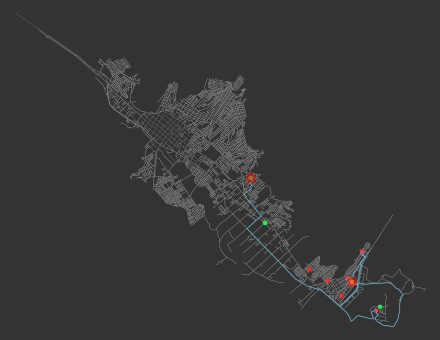

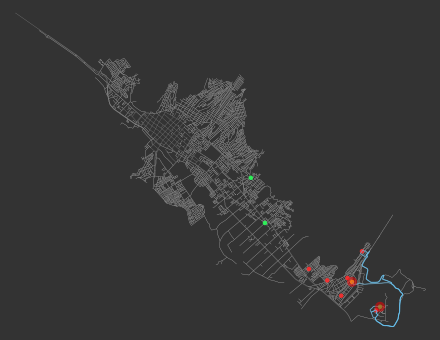

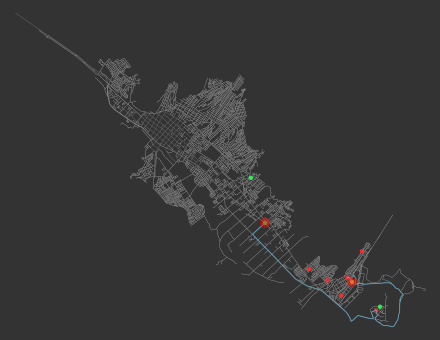

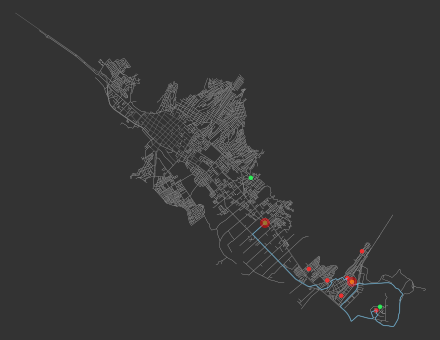

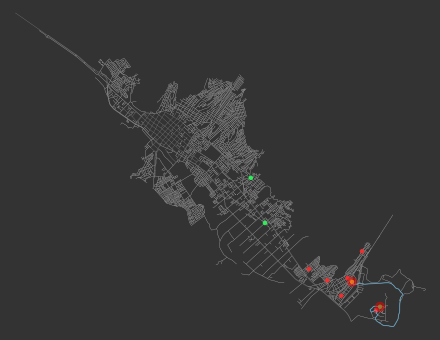

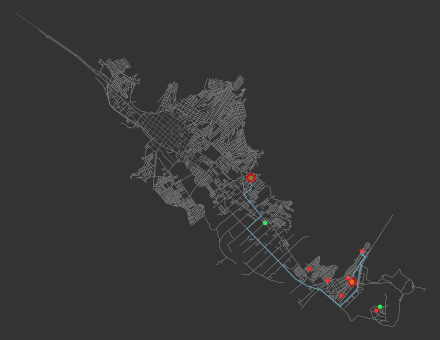

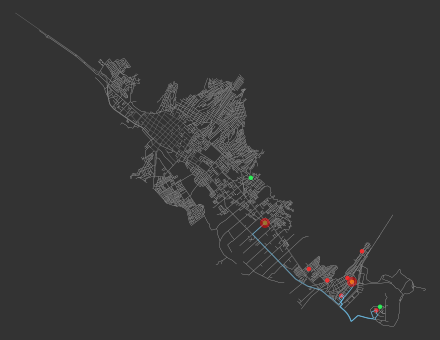

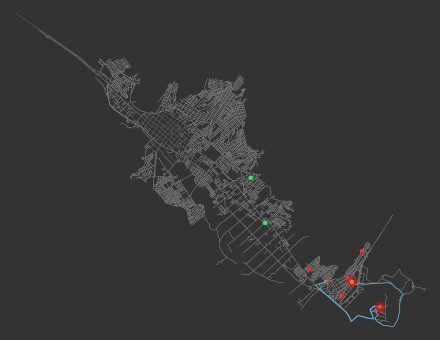

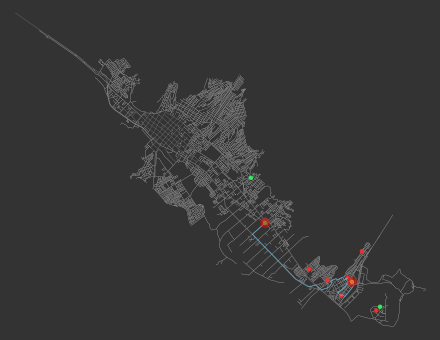

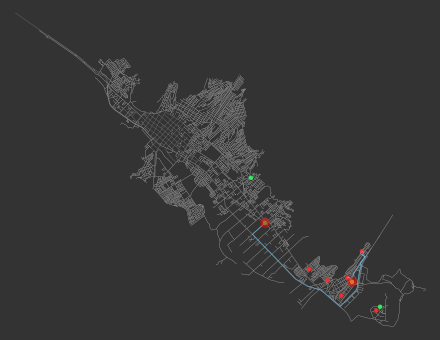

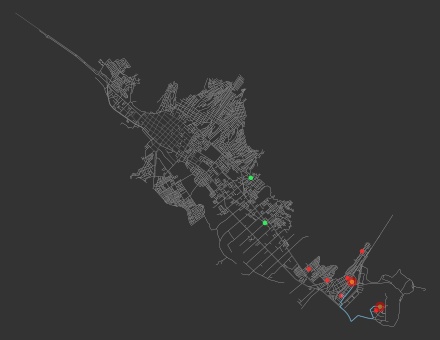

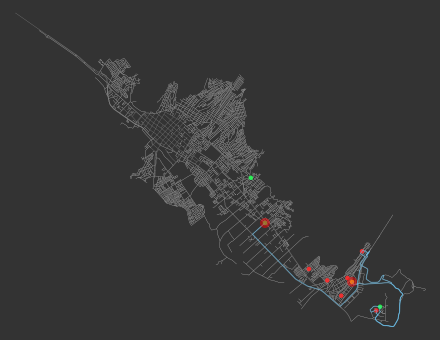

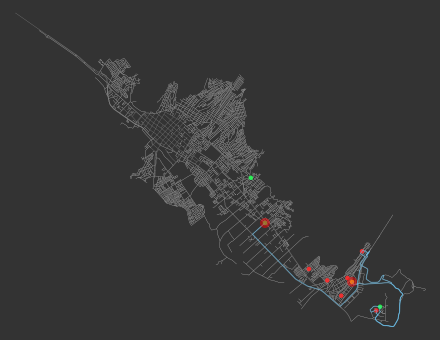

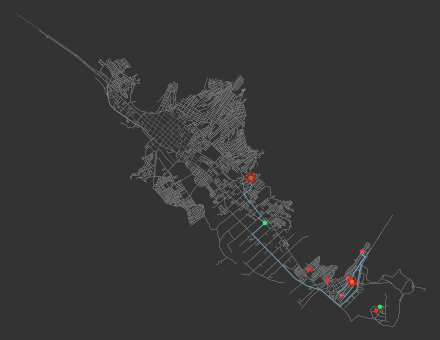

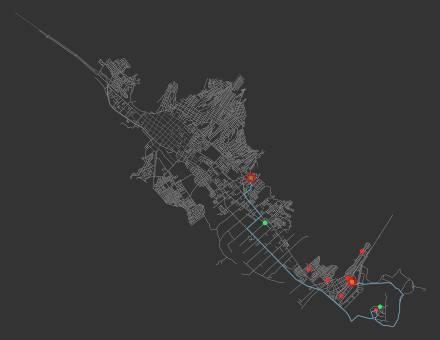

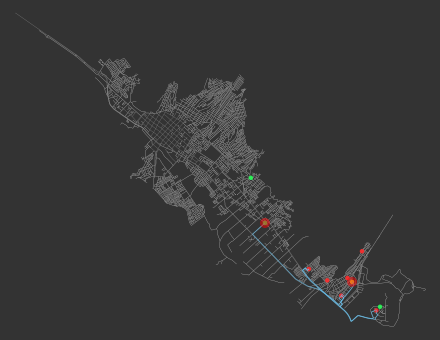

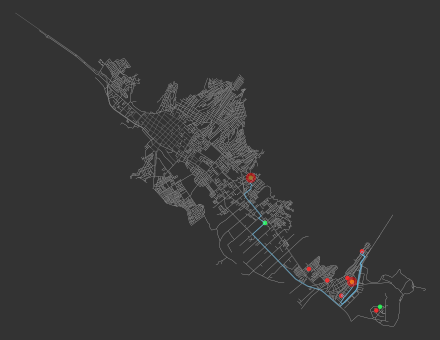

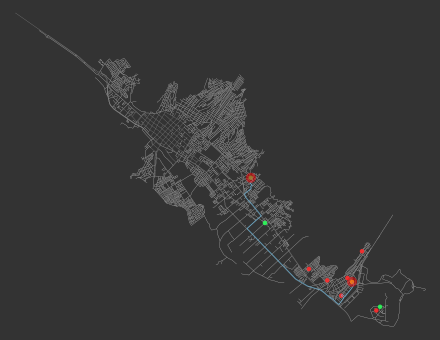

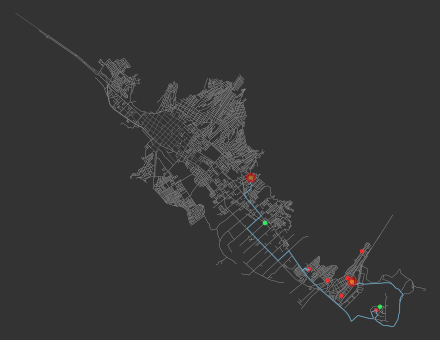

In [20]:
node_color = []
node_size = []
for node in G.nodes:
    if node in ox_nodes[:1]:
        node_color.append('#eaff2b')
        node_size.append(20)
    elif node in ox_nodes[1:7]:
        node_color.append('#ff2b2b')
        node_size.append(20)
    elif node in ox_nodes[7:]:
        node_color.append('#2bff59')
        node_size.append(20)
    elif node in ox_nodes0:
        node_color.append('#66ccff')
        node_size.append(0)
    else:
        node_color.append('#66ccff')
        node_size.append(0)

nx_routes = []
for route in routes:
    ox_route = [ox_nodes[i] for i in routes[route]]
    nx_route = [ox_route[0]]
    for i in range(len(ox_route[:-1])):
        nx_route += nx.shortest_path(G, source=ox_route[i], target=ox_route[i+1])[1:]

    fig, ax = ox.plot_graph_route(G, nx_route, node_color=node_color, node_size=node_size, dpi=1500, save=True, node_zorder=3, node_alpha=0.9,
                           bgcolor='#333333', edge_color='#a8a8a8', edge_linewidth=0.2, route_linewidth=1, route_color='#66ccff', filename='route_{}'.format(route))
    fig.savefig('instances/paipote/routes/route0.png', dpi=1500, facecolor='#333333')

In [24]:
nx_routes = []
for route in routes:
    ox_route = [ox_nodes[i] for i in routes[route]]
    nx_route = [ox_route[0]]
    for i in range(len(ox_route[:-1])):
        nx_route += nx.shortest_path(G, source=ox_route[i], target=ox_route[i+1])[1:]
    nx_routes.append(nx_route)

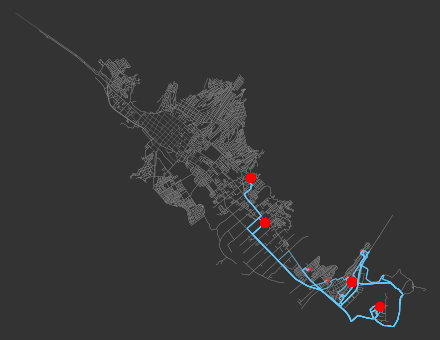

In [26]:
fig, ax = ox.plot_graph_routes(G, nx_routes, node_color=node_color, node_size=node_size, dpi=1500, save=True, node_zorder=3, node_alpha=0.9,
                           bgcolor='#333333', edge_color='#a8a8a8', edge_linewidth=0.2, route_linewidth=1, route_color='#66ccff', filename='route_{}'.format(route))